In [3]:
# Anomaly detection on Yahoo Benchmark

#--------------------------
# Step 1 Import Libraries
#--------------------------

import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import pdf as pdf
import tensorflow as tf
import os
from tensorflow import keras
import seaborn as sns
from scipy.stats import norm
from scipy.stats import lognorm
from scipy import stats
import math

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score


In [4]:
#----------------------
# Step 2 Load Dataset
# ---------------------
os.chdir('/Users/sylviachadha/Desktop/Anomaly_Detection/Practice_Dataset')
df = pd.read_csv('real_51.csv', index_col = 'timestamp')
print(df.head(6))

           value  is_anomaly
timestamp                   
1              0           0
2             45           0
3           1492           0
4           1608           0
5           1839           0
6           1830           0


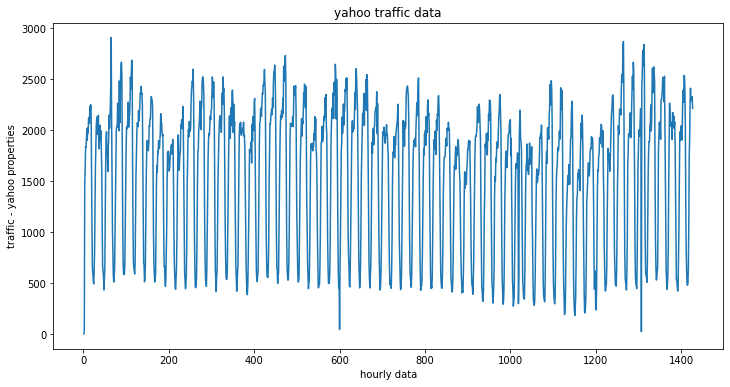

In [5]:
#-------------------
# Step3 Plot data
#-------------------
ax = df['value'].plot(figsize = (12,6), title = 'yahoo traffic data');
xlabel = 'hourly data'
ylabel = 'traffic - yahoo properties'
ax.set(xlabel = xlabel, ylabel = ylabel)
plt.show()

In [6]:
# ------------------------------------
# Step4 Train, Validation, Test Split
# ------------------------------------

train_size = 0.70
validation_size = 0.15
test_size = 0.15


train, remain = train_test_split(df, test_size=(validation_size + test_size),shuffle=False)

new_test_size = np.around(test_size / (validation_size + test_size), 2)
# To preserve (new_test_size + new_val_size) = 1.0
new_val_size = 1.0 - new_test_size

val, test = train_test_split(remain, test_size=new_test_size,shuffle=False)

print(train)
print(val)
print(test)

len(df)

           value  is_anomaly
timestamp                   
1              0           0
2             45           0
3           1492           0
4           1608           0
5           1839           0
...          ...         ...
994         1835           0
995         1948           0
996         1969           0
997         1973           0
998         2076           0

[998 rows x 2 columns]
           value  is_anomaly
timestamp                   
999         2073           0
1000        2103           0
1001        1750           0
1002        1919           0
1003        1399           0
...          ...         ...
1208        1764           0
1209        1923           0
1210        1870           0
1211        1924           0
1212        2018           0

[214 rows x 2 columns]
           value  is_anomaly
timestamp                   
1213        2058           0
1214        2036           0
1215        1845           0
1216        1832           0
1217        1994        

1427

In [7]:
# Store Actual labels for val data to use for threshold decision later

no_of_time_steps=10
print(val)
len(val)
val_actual = val.iloc[no_of_time_steps:]
print(val_actual)

# Store Actual labels for test data to use for confusion matrix evaluation

no_of_time_steps=10
print(test)
len(test)
test_actual = test.iloc[no_of_time_steps:]
print(test_actual)


           value  is_anomaly
timestamp                   
999         2073           0
1000        2103           0
1001        1750           0
1002        1919           0
1003        1399           0
...          ...         ...
1208        1764           0
1209        1923           0
1210        1870           0
1211        1924           0
1212        2018           0

[214 rows x 2 columns]
           value  is_anomaly
timestamp                   
1009         366           0
1010         758           0
1011        1063           0
1012        1481           0
1013        1672           0
...          ...         ...
1208        1764           0
1209        1923           0
1210        1870           0
1211        1924           0
1212        2018           0

[204 rows x 2 columns]
           value  is_anomaly
timestamp                   
1213        2058           0
1214        2036           0
1215        1845           0
1216        1832           0
1217        1994        

In [8]:
# Check ratio of classes (Normal vs Anomalies)
df['is_anomaly'].value_counts()

0    1423
1       4
Name: is_anomaly, dtype: int64

In [9]:
# To check how many anomalies are present in Training and how many in validation and test
a = train.loc[train.is_anomaly == 1]
print(a)
total_rowsa = a['is_anomaly'].count()
print('is_anomaly_training_count',total_rowsa)


b = val.loc[val.is_anomaly == 1]
print(b)
total_rowsb = b['is_anomaly'].count()
print('is_anomaly_val_count',total_rowsb)

c = test.loc[test.is_anomaly == 1]
print(c)
total_rowsc = c['is_anomaly'].count()
print('is_anomaly_test_count',total_rowsc)

           value  is_anomaly
timestamp                   
600           45           1
is_anomaly_training_count 1
           value  is_anomaly
timestamp                   
1019         298           1
1020         617           1
is_anomaly_val_count 2
           value  is_anomaly
timestamp                   
1307          22           1
is_anomaly_test_count 1


In [10]:
# Remove is_anomaly = 1 rows from only train data
train = train.drop(train[train.is_anomaly == 1].index)
print('new_train_count',train['value'].count())

# Just to confirm no anomaly in training set
c = train.loc[train.is_anomaly == 1]
total_rows = c['is_anomaly'].count()
print('is_anomaly_training_count',total_rows)

# Remove is_anomaly column from train and test data 

del train['is_anomaly']
del test['is_anomaly']

print(train.shape, test.shape)

new_train_count 997
is_anomaly_training_count 0
(997, 1) (215, 1)


In [11]:
#-------------------------
# Step 5 Scaling of data
#-------------------------
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler = scaler.fit(train[['value']])

train['value'] = scaler.transform(train[['value']])
val['value'] = scaler.transform(val[['value']])
test['value'] = scaler.transform(test[['value']])

<ipython-input-11-fe9aeee93c64>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['value'] = scaler.transform(val[['value']])
<ipython-input-11-fe9aeee93c64>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['value'] = scaler.transform(test[['value']])


In [12]:
#-----------------------------------
# Step 6 - Prepare Input for LSTM
#-----------------------------------
# We’ll split the data into sub-sequences - changing input to a shape as accepted by
# lstm autoencoder

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS=10

# Reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(
  train[['value']],
  train.value,
  TIME_STEPS
)

X_val, y_val = create_dataset(
  val[['value']],
  val.value,
  TIME_STEPS
)

X_test, y_test = create_dataset(
  test[['value']],
  test.value,
  TIME_STEPS
)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)


(987, 10, 1)
(204, 10, 1)
(205, 10, 1)


In [13]:
#-----------------------------------
# Step 7 Define Model Architecture
#-----------------------------------

model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=32,
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=32, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(
  keras.layers.TimeDistributed(
    keras.layers.Dense(units=X_train.shape[2])
  )
)
model.compile(loss='mae', optimizer='adam')



In [14]:
#----------------------------
# Step 8 Training/Fit Model
#----------------------------

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=10,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/50
89/89 [==============================] - 2s 26ms/step - loss: 0.3457 - val_loss: 0.2319
Epoch 2/50
89/89 [==============================] - 1s 10ms/step - loss: 0.2363 - val_loss: 0.1737
Epoch 3/50
89/89 [==============================] - 1s 9ms/step - loss: 0.2083 - val_loss: 0.1511
Epoch 4/50
89/89 [==============================] - 1s 9ms/step - loss: 0.1906 - val_loss: 0.1372
Epoch 5/50
89/89 [==============================] - 1s 9ms/step - loss: 0.1787 - val_loss: 0.1238
Epoch 6/50
89/89 [==============================] - 1s 13ms/step - loss: 0.1624 - val_loss: 0.1069
Epoch 7/50
89/89 [==============================] - 1s 10ms/step - loss: 0.1585 - val_loss: 0.1030
Epoch 8/50
89/89 [==============================] - 1s 11ms/step - loss: 0.1479 - val_loss: 0.0964
Epoch 9/50
89/89 [==============================] - 1s 12ms/step - loss: 0.1424 - val_loss: 0.0951
Epoch 10/50
89/89 [==============================] - 1s 9ms/step - loss: 0.1388 - val_loss: 0.0950
Epoch 11/50
8

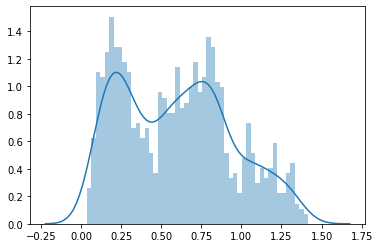

Mean and S.D obtained using MLE on training prediction errors is (0.5961932535011338, 0.3435544880636246)


In [15]:
#------------------------------------------------------------
# Step 9 Predict & decide parameters using MLE on Training data
#------------------------------------------------------------
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

# Show distribution plot of training loss
sns.distplot(train_mae_loss, bins=50, kde=True);
plt.show()

train_mae_loss = train_mae_loss.flatten()

# We normally assume distributions on errors/residuals
# Assume guassian distribution for prediction errors on training data
train_mae_loss

# Use MLE to estimate best parameters for above prediction errors
parameters = norm.fit(train_mae_loss)
print ("Mean and S.D obtained using MLE on training prediction errors is",parameters)


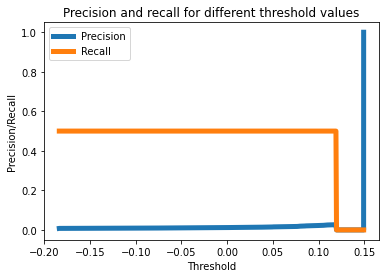

In [16]:
#-----------------------------------------------
# Step 10 - Method to decide on Threshold value
#-----------------------------------------------

# Apply trained model on validation set and get validation prediction errors
# Adding anomalies of Training as well to validation


X_val_pred = model.predict(X_val)

val_mae_loss = np.mean(np.abs(X_val_pred - X_val), axis=1)
len(val_mae_loss)

# Compute probability values for errors on validation set

prob_val_mae_loss = norm.pdf(val_mae_loss, loc=parameters[0], scale=parameters[1])
prob_val_mae_loss = prob_val_mae_loss.flatten()
prob_val_mae_loss_log = np.log(prob_val_mae_loss)
prob_val_mae_loss_log

# A threshold is set on the log probability distribution values

#----------------#
# Assumptions
#----------------#
# 1. An anomaly is an observation which is suspected of being partially or wholly irrelevant
# because it is not generated by the stochastic model assumed.Above we assumed guassian
# distribution on training errors train_mae_loss

# 2. Normal data instances occur in high probability regions of a stochastic model,
# while anomalies occur in the low probability regions of the stochastic model.
# This assumption is checked below where low Probability density instances should be
# captured as anomalies

error_df = pd.DataFrame({'probability_val_set': prob_val_mae_loss_log,
                        'True_class_val_set': val_actual['is_anomaly']})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class_val_set,error_df.probability_val_set)

plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)

plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)

plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [ ]:
# See values of different thresholds as per precision_recall_curve function
print(threshold_rt)
print(precision_rt)
print(recall_rt)

In [ ]:
# Choose threshold which maximize the F1 Score

f1_scores = 2*recall_rt*precision_rt/(recall_rt+precision_rt)

selected_threshold = threshold_rt[np.argmax(f1_scores)]
print('Best threshold: ', threshold_rt[np.argmax(f1_scores)])
print('Best F1-Score: ', np.max(f1_scores))

In [ ]:
#-----------------------------------------------
# Step 13 - Get predictions on test set
#-----------------------------------------------

X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)
len(test_mae_loss)

# Compute probability values for errors on test set

prob_test_mae_loss = norm.pdf(test_mae_loss, loc=parameters[0], scale=parameters[1])
prob_test_mae_loss = prob_test_mae_loss.flatten()
prob_test_mae_loss_log = np.log(prob_test_mae_loss)
prob_test_mae_loss_log

In [ ]:
#-----------------------------------------------
# Step 12 - Evaluate this threshold on test set
#-----------------------------------------------

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = prob_test_mae_loss_log
test_score_df['threshold'] = selected_threshold
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['anomaly'] = test_score_df['anomaly'].astype(int)
test_score_df['value'] = test[TIME_STEPS:].value

In [ ]:
#--------------------------------------------
# Step 13 Plot Test Loss and Threshold
#---------------------------------------------
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();
plt.show()

In [ ]:
#---------------------------------------------
# Step 14 Print Anomalies Actual and Predicted
#---------------------------------------------

anomalies = test_score_df[test_score_df.anomaly == 1]
print ('ACTUAL ANOMALIES count',len(d))
print('ACTUAL ANOMALIES',d)
print ('DETECTED ANOMALIES count',len(anomalies))
print('DETECTED ANOMALIES', anomalies)

In [ ]:
#---------------------------------------------------------------------
# Step 15 Evaluation metrics with test_actual and test_score_df
# Confusion Matrix
#---------------------------------------------------------------------
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(test_actual['is_anomaly'],test_score_df['anomaly'])
print('Confusion Matrix')
print(cf)

[-0.183761   -0.1836637  -0.18193514 -0.17753018 -0.17243201 -0.15866427
 -0.15655702 -0.1528003  -0.14735112 -0.14489997 -0.14020616 -0.1328966
 -0.13082412 -0.13053475 -0.12966032 -0.12722797 -0.12511609 -0.12143725
 -0.1150243  -0.09796963 -0.09558425 -0.09452331 -0.090805   -0.08427682
 -0.07717723 -0.07702175 -0.07686788 -0.07324743 -0.06719087 -0.06567931
 -0.06528709 -0.0644625  -0.05711525 -0.05626225 -0.04245823 -0.04236749
 -0.0360683  -0.0325578  -0.03171081 -0.02738114 -0.02684969 -0.01807039
 -0.01731466 -0.01208076 -0.00729494 -0.00605664 -0.00301889 -0.00021947
  0.00174523  0.00397794  0.0061168   0.00794551  0.01034778  0.01080194
  0.01149795  0.01300967  0.01503523  0.02245249  0.03331241  0.03820779
  0.04251407  0.04531889  0.04724531  0.04906562  0.04934715  0.04967767
  0.05068337  0.05438803  0.05832332  0.05852149  0.06600528  0.06716067
  0.07185953  0.07242581  0.07665054  0.07796112  0.07852028  0.07904819
  0.0794923   0.08210288  0.08511227  0.08551542  0.

In [18]:
# Choose threshold which maximize the F1 Score

f1_scores = 2*recall_rt*precision_rt/(recall_rt+precision_rt)

selected_threshold = threshold_rt[np.argmax(f1_scores)]
print('Best threshold: ', threshold_rt[np.argmax(f1_scores)])
print('Best F1-Score: ', np.max(f1_scores))

Best threshold:  0.1229132037218834
Best F1-Score:  nan


<ipython-input-18-67a9119c4182>:3: RuntimeWarning: invalid value encountered in true_divide
  f1_scores = 2*recall_rt*precision_rt/(recall_rt+precision_rt)


In [19]:
#-----------------------------------------------
# Step 13 - Get predictions on test set
#-----------------------------------------------

X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)
len(test_mae_loss)

# Compute probability values for errors on test set

prob_test_mae_loss = norm.pdf(test_mae_loss, loc=parameters[0], scale=parameters[1])
prob_test_mae_loss = prob_test_mae_loss.flatten()
prob_test_mae_loss_log = np.log(prob_test_mae_loss)
prob_test_mae_loss_log

array([-0.26310744,  0.02633211,  0.14942247,  0.04887917,  0.0648278 ,
        0.13421759, -0.07641989, -0.21953997,  0.01905363,  0.13145933,
        0.1266124 , -0.02746628, -0.25400576, -0.27164887, -0.22895882,
       -0.14749426, -0.15050547, -0.07811661, -0.13395069, -0.31280123,
       -0.52293034, -0.62779005, -1.42651102, -1.22572159, -0.7598674 ,
       -0.22178779,  0.12319432,  0.13989062,  0.14360221,  0.01544448,
       -0.11857588, -0.24451058, -0.01973624,  0.0960052 ,  0.14569182,
        0.12862945,  0.00396132, -0.30901092, -0.32448391, -0.25670041,
       -0.54534849, -0.56254726, -0.31925642, -0.39067008, -0.06089451,
       -2.25332587, -2.73576669, -2.33844077, -1.60751339, -0.62986225,
       -0.06479345,  0.09180488,  0.09677396, -0.08339122, -0.18024289,
       -0.17600964,  0.02483412,  0.14349135,  0.14795585,  0.10882323,
       -0.14907983, -0.61456421, -0.6216968 , -0.35769204, -0.17815293,
       -0.39288467, -0.22570546, -0.43706688,  0.13966044, -1.12

In [20]:
#-----------------------------------------------
# Step 12 - Evaluate this threshold on test set
#-----------------------------------------------

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = prob_test_mae_loss_log
test_score_df['threshold'] = selected_threshold
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['anomaly'] = test_score_df['anomaly'].astype(int)
test_score_df['value'] = test[TIME_STEPS:].value

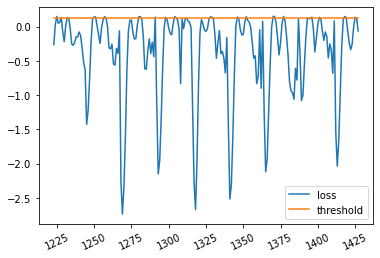

In [21]:
#--------------------------------------------
# Step 13 Plot Test Loss and Threshold
#---------------------------------------------
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();
plt.show()

In [22]:
#---------------------------------------------
# Step 14 Print Anomalies Actual and Predicted
#---------------------------------------------

anomalies = test_score_df[test_score_df.anomaly == 1]
print ('ACTUAL ANOMALIES count',len(d))
print('ACTUAL ANOMALIES',d)
print ('DETECTED ANOMALIES count',len(anomalies))
print('DETECTED ANOMALIES', anomalies)

ACTUAL ANOMALIES count 1
ACTUAL ANOMALIES            value  is_anomaly
timestamp                   
1307          22           1
DETECTED ANOMALIES count 29
DETECTED ANOMALIES                loss  threshold  anomaly     value
timestamp                                        
1225       0.149422   0.122913        1 -1.174757
1228       0.134218   0.122913        1 -0.270962
1232       0.131459   0.122913        1 -0.092674
1233       0.126612   0.122913        1 -0.201236
1249       0.123194   0.122913        1 -1.072374
1250       0.139891   0.122913        1 -0.750221
1251       0.143602   0.122913        1 -0.328332
1257       0.145692   0.122913        1  0.337158
1258       0.128629   0.122913        1  0.340688
1280       0.143491   0.122913        1  0.268314
1281       0.147956   0.122913        1  0.304501
1291       0.139660   0.122913        1 -0.219771
1298       0.136002   0.122913        1 -0.580759
1304       0.147343   0.122913        1  0.223301
1305       0.129695   0.

In [23]:
#---------------------------------------------------------------------
# Step 15 Evaluation metrics with test_actual and test_score_df
# Confusion Matrix
#---------------------------------------------------------------------
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(test_actual['is_anomaly'],test_score_df['anomaly'])
print('Confusion Matrix')
print(cf)

Confusion Matrix
[[175  29]
 [  1   0]]
